### 목표
- 버섯의 특징을 활용해 독/식용 버섯인지 예측하는 이진분류 모델을 만들어보자!
- DecisionTree 시각화 & 과대적합 속성 제어
- 특성 중요도 확인 => 특성 선택

In [1]:
# 환경 셋팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # tree 분류
from sklearn.model_selection import train_test_split # 랜덤 샘플링
from sklearn.metrics import accuracy_score

### 데이터 불러오기

In [2]:
# 열 전체 다 보여주게 설정하기
pd.set_option('display.max_columns',None)

In [3]:
# data 변수
# dp => csv 파일 읽는 함수
# data = pd.read_csv(경로 및 파일명)
data = pd.read_csv('./data/mushroom.csv')
data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [4]:
# 크기
data.shape
# 행이 8124
# 열 - label(1),featur(22)

(8124, 23)

In [5]:
# data의 정보를 확인하는 것( 열의 이름을 가장 상세하게 잘 볼 수 있음 )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### 데이터 전처리 및 탐색

#### 문제(특성)와 답(Label)분리

In [6]:
# X는 특성임 특성이 굉장히 많음 => 차원이 굉장히 크니까 X도 대문자를 쓰는거임
# 열 인덱싱(접근)
X = data.iloc[ : , 1: 23]  # label 제외한 나머지 컬럼
# 열은 작음 몇개 없음 그래서 소문자로 쓰는 것임
y = data.iloc[ : , : 1 ]   # label컬럼

In [7]:
print(X.shape)
print(y.shape)

(8124, 22)
(8124, 1)


In [8]:
# 기술통계량 확인하기
# 평균 최소 최대 중앙은 뽑을 수는 없음 ==> 문자열 이라서
# 현재 데이터가 문자열(범주형) 평균, 중앙 뽑기에 어려운 상황
# describe()
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
# y값 식용/ 독버섯 몇개씩 들어있는지 확인
# y는 판다스니까 value count 사용
y.value_counts()
# p -> 독버섯(poision)
# e- > 식용버섯(eatable)

poisonous
e            4208
p            3916
dtype: int64

#### 인코딩
- 머신러닝을 숫자를 학습할 수 있다.
- 문자열 > 숫자 형태로 변형 : encoding
- encoding  방식 1) 레이블 인코딩 : 데이터의 크고 작음의 의미가 있을 때 2) 원핫인 코딩 : 크고 작음의 의미가 없을때, 그 자체로 의미를 가질 때

In [10]:
# 버섯 특성 데이터 > 원핫 인코딩
# pd.get_dummies(대상) # one hot encoding 진행하는 함수
X_oh = pd.get_dummies(X)  # 문제변수 X를 전부 onhot encoding 해준것임
X_oh.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_?,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


추가설명 ) 레이블 인코딩 예시

In [11]:
X['habitat'].unique()  # 갯수가 몇개인지 파악

array(['u', 'g', 'm', 'd', 'p', 'w', 'l'], dtype=object)

In [12]:
habitate_dic = {
    'u' : 2 ,
    'g' : 1 ,
    'm' : 3 , 
    'd' : 5 ,
    'p' : 4 ,
    'w' : 7 ,
    'l'  :6 ,
}
# 맵핑 --> 문자를 숫자로 매핑 시켜줌 
X['habitat'].map(habitate_dic)


0       2
1       1
2       3
3       2
4       1
       ..
8119    6
8120    6
8121    6
8122    6
8123    6
Name: habitat, Length: 8124, dtype: int64

In [13]:
# train, test분리
# 테스트 사이즈 : 30 % => 7 : 3
# 랜덤 샘플링 고정값 => 0
# onehot 인코딩 한거를 넣어줘야함 => X_oh
X_train,X_test ,y_train,y_test = train_test_split(X_oh,y, test_size= 0.3, random_state=0)
# random_state ==> 랜덤하게 섞는 것을 방지하기 위해 고정하려고 사용하는 친구
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5686, 117)
(5686, 1)
(2438, 117)
(2438, 1)


In [14]:
X_train
# tree 모델 : 특성 1개를 기준으로 질문을 던지고, 반복적으로 질문하며 학습 진행

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_?,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
5314,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2075,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
5165,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1155,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4448,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3264,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1653,0,0,0,0,0,1,0,0,1,0

### 모델링
#### 모델 생성 및 학습

In [15]:
# 객체 생성
tree_model = DecisionTreeClassifier()

# 트리 모델은 과대적합에 걸리기 쉬운 모델
# 하이퍼 파라미터 값의 기본 값이 제한적이지 X(독스트링 확인 해보면 최소 리프 값이 1임
#                                               -> 이러면 최소가 너무 적으니까 계속 늘어갈꺼고 그럼 과대적합이 되는거임)
# 데이터를 받아들이면서 Random하게 섞는 작업 진행 > 크게 차이가 나지 않지만 
#                                                   데이터를 보는 순서에 따라 모델의 규칙 생성이 미묘하게 변할 수 있다.

In [16]:
# 학습
tree_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [17]:
# 예측
# 새로운 문제
# predict(X_test)
pre = tree_model.predict(X_test)
pre

array(['p', 'e', 'e', ..., 'p', 'p', 'p'], dtype=object)

In [18]:
# 원본의 특성을 입력( 웹 tomcat server, 앱 ) > Python 코드로 넘기기(flask서버) > 전처리 > Model 연결 > 예측 결과
#   > 웹, 앱 전달 후 화면에서 결과 확인

In [19]:
# 성능 평가
# model.score(문제,답)을 집어넣음 > 정확도 출력 가능(모델 안에 있는 정확도 측정 사용)
tree_model.score(X_test,y_test)  # 100%가 나옴

1.0

#### 교차 검증
- 개념 : 일반화 성능 측정 방법 => 모든 (어떤) 어떤 데이터에 대해 모델이 얼마나 잘 맞추는지 평가 하는 방법. 한번 평가하는 것 보다는 여러번 평가하는 것이 안정적이다.
- 방법론 : 검증용 데이터셋을 여러겹 나눠서 평가하는 방법
- 모델을 정의하고 학습하기 전에 정확도가 어느정도인지 확인할때도 사용 가능 

In [20]:
# import 써서 평가하는 거
accuracy_score(y_test,pre)

1.0

In [21]:
# 교차 검증 도구 sklearn에서 제공
from sklearn.model_selection import cross_val_score


In [22]:
# estimator : 예측기 => 모델
# 교차검증 사용하는 데이터 : train
# cv (cross valudation): 교차검증 횟수 지정, 검증 데이터 개수 지정 => 일반적으로 3,5번 돌림
result = cross_val_score(tree_model, X_train, y_train,cv = 5 )
print(result)
print(result.mean())
# 결과를 보면 여러개의 검증(테스트) 데이터가 들어와도 성능이 일반적으로 높게 나옴
# 현재 과대적합을 제어하진 않았지만 일반화 모델이라 정의할 수 있겠음!
# 예측하기 쉬운 데이터를 사용하고 있기때문에 많이 작업이 필요없는 상태

[1.         1.         1.         1.         0.99912049]
0.9998240985048372


### 특성 선택
- tree_model 특성 중요도 확인
- 클래스를 분류하기 위해서 어떤 질문(특성)을 중요하게 여겼을까?

In [23]:
#특성 중요도 출력
fi = tree_model.feature_importances_
# 0.00000000e+00 이런식으로 나와서 바꿔줘야함
fi.shape   # 각 특성에 대한 중요도(수치값)확인

(117,)

In [24]:
# 특성 중요도 쉽게 확인(ascending =False 내림차순으로!!)
# pandas 객체 형식으로 바꿔서 보겠다!
import_df = pd.DataFrame(fi ,index= X_oh.columns)
import_df.sort_values(by = 0,ascending= False ).head(10)
# 해당 특성을 기준으로 분리 했을 때의 불순도 파악 > 지니 불순도
# 불순도가 낮게 출력되는 특성을 기준으로 제일 먼저 질문을 한다.

,0
odor_n,0.624704
stalk-root_c,0.169466
stalk-surface-below-ring_y,0.100237
spore-print-color_r,0.034145
spore-print-color_u,0.023820
stalk-surface-above-ring_s,0.018234
odor_l,0.010401
odor_a,0.009110
ring-type_e,0.005668
cap-surface_g,0.002105


### 시각화
- tree 모델 학습 현황 시각화
- graphviz 시각화 도구 사용(설치 필요!)

In [25]:
from sklearn.tree import export_graphviz
import graphviz

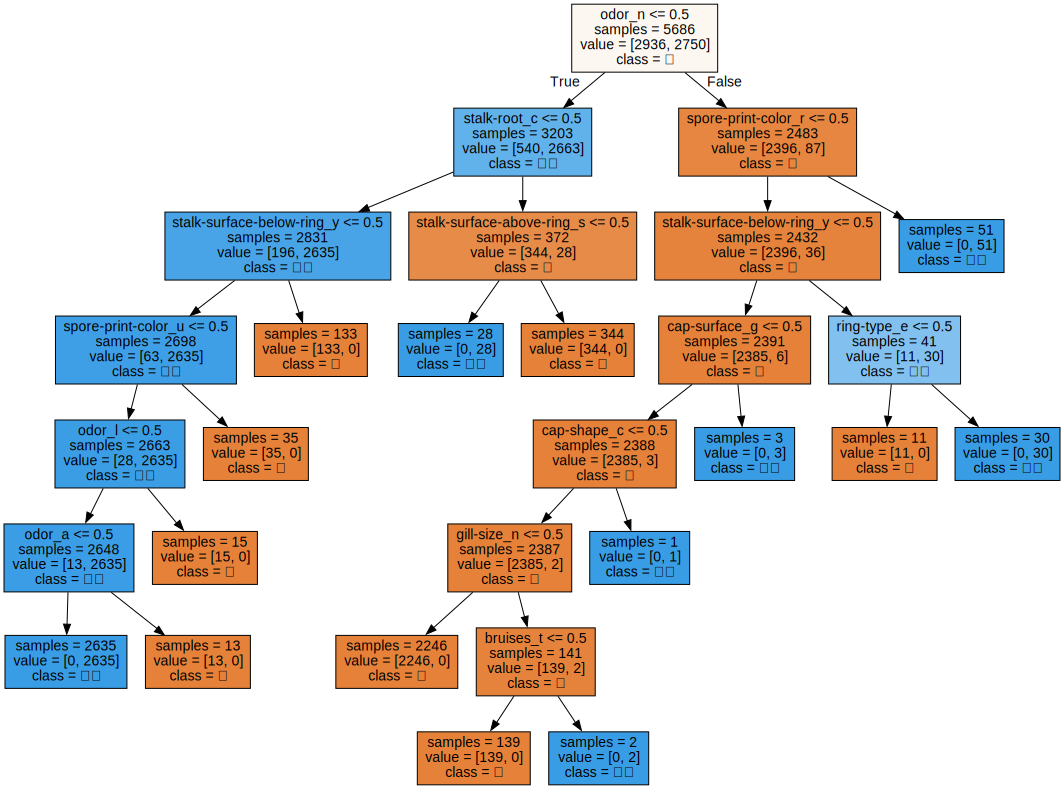

In [26]:
# 학습시킨 모델의 학습 현황 추출
export_graphviz(tree_model, out_file='tree.dot',
                class_names=['독','식용'],
                feature_names=X_oh.columns,
                impurity=False,
                filled=True)

# 주피터 내에서 시각화 하는 코드
with open('tree.dot', encoding='UTF8') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

### 과대적합 제어 후 시각화 확인

In [33]:
# 모델의 복잡도 제어 : 모델 안에 하이퍼 파라미터 총 4개!
# 사전 가지치기 > 깊이 제어
# max_depth
tree_model2 = DecisionTreeClassifier(max_depth=3)
tree_model2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [34]:
#교차검증
cross_val_score(tree_model2,X_train,y_train,cv = 5)

array([0.98594025, 0.98328936, 0.9885664 , 0.98504837, 0.98680739])

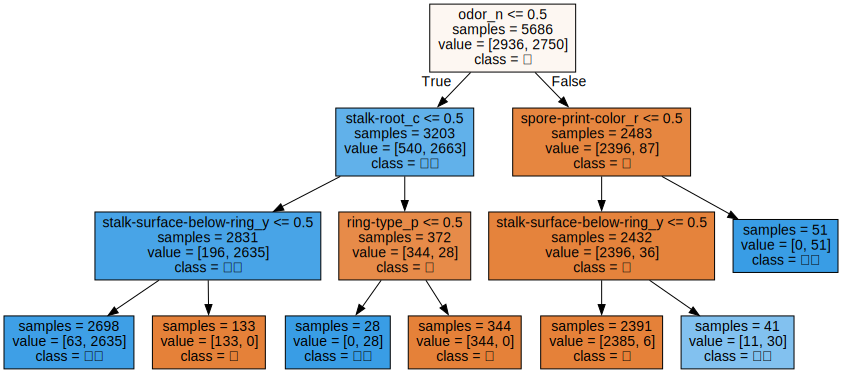

In [35]:
# 학습시킨 모델의 학습 현황 추출
export_graphviz(tree_model2, out_file='tree.dot',
                class_names=['독','식용'],
                feature_names=X_oh.columns,
                impurity=False,
                filled=True)

# 주피터 내에서 시각화 하는 코드
with open('tree.dot', encoding='UTF8') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [ ]:
# 현재 데이터 기준으로 과대적합 제어 필요 없음
# 시각화 위해 한번 진행해봄!
# 위에 보면 max_depth나 leaf 뭐 그런거 바꿔서 얼만큼 변하는지 확인 해보기